## Crank-Nicolson Method

In [66]:
import numpy as np
from scipy.linalg import solve_banded

class CrankNicolsonSolver:
    def __init__(self, riskfree, dividend, volatility, strike, maturity, option_type="put"):
        self.r = riskfree
        self.q = dividend
        self.sigma = volatility
        self.K = strike
        self.T = maturity
        self.option_type = option_type.lower()  # "put" or "call"
        self.Smax = 3 * strike
        self.x_min = -5  # S -> 0
        self.x_max = 5   # S -> inf
        self.N = 200
        self.max_dt = 1/12.0
        self.USE_PSOR = False
        self.tol = 1e-5
        self.max_iter = 200
        self.omega = 1.2
        self.cached_dt = 0
        self.err = 0
        self.iter = 0

        self.x = np.linspace(self.x_min, self.x_max, self.N)  # log price grid
        self.S = np.exp(self.x)  # Convert x to S
        self.A = np.zeros((self.N, self.N))
        self.b = np.zeros((self.N, 1))
        self.X = np.zeros(self.N)

    def solve(self, S0):
        self.setInitialCondition()
        self.solvePDE()
        prices = np.exp(self.x)  # Convert back from log prices to actual prices
        return np.interp(S0, prices, self.X)

    def solvePDE(self):
        t = self.T
        while t > 0:
            dt = min(t, self.max_dt)
            self.setCoeff(dt ,t)
            if self.USE_PSOR:
                self.solvePSOR()
            else:
                self.solveLinearSystem()
            t -= dt
            print(f"t = {t:.5f}, err = {self.err:.5e}, iters = {self.iter}")

    def setInitialCondition(self):
        if self.option_type == "put":
            self.X = np.maximum(self.K - self.S, 0)  # Put Option Payoff
        elif self.option_type == "call":
            self.X = np.maximum(self.S - self.K, 0)  # Call Option Payoff

    def setCoeff(self, dt, t):
        N = self.N
        dx = self.x[1] - self.x[0]
        alpha = 0.25 * dt * (self.sigma**2 / dx**2)
        beta = 0.25 * dt * ((self.r - self.q - 0.5 * self.sigma**2) / dx)
        gamma = 0.5 * dt * self.r

        for i in range(1, N - 1):  # Corrected to avoid out-of-bounds indexing
            self.A[i, i - 1] = -alpha + beta  # Left neighbor
            self.A[i, i] = 1 + 2 * alpha + gamma  # Center
            self.A[i, i + 1] = -alpha - beta  # Right neighbor

            self.b[i] = alpha * self.X[i - 1] + (1 - 2 * alpha - gamma) * self.X[i] + alpha * self.X[i + 1]

        # Boundary conditions
        if self.option_type == "put":
            self.A[0, 0] = 1
            self.A[0, 1] = 0
            self.b[0] = self.K * np.exp(-self.r * t) - self.S[0]  # Left boundary (S -> 0)

            self.A[-1, -1] = 1
            self.A[-1, -2] = 0
            self.b[-1] = 0  # Right boundary (S -> ∞)

        elif self.option_type == "call":
            self.A[0, 0] = 1
            self.A[0, 1] = 0
            self.b[0] = 0  # Left boundary (S -> 0)

            self.A[-1, -1] = 1
            self.A[-1, -2] = 0
            self.b[-1] = self.S[-1] - self.K * np.exp(-self.r * t)  # Right boundary (S -> ∞)
        else:
            raise ValueError("Invalid option type")

    def solveLinearSystem(self):
        # Extract diagonals for banded solver
        lower = np.diag(self.A, k=-1)
        main = np.diag(self.A, k=0)
        upper = np.diag(self.A, k=1)
        ab = np.zeros((3, self.N))
        ab[0, 1:] = upper
        ab[1, :] = main
        ab[2, :-1] = lower
        # Solve using banded solver
        self.X = solve_banded((1, 1), ab, self.b.flatten())
        # self.X = np.linalg.solve(self.A, self.b).flatten()

    def solvePSOR(self):
        N = self.N
        iter = 0
        omega = self.omega
        self.err = 1e10
        while self.err > self.tol and iter < self.max_iter:
            iter += 1
            x_old = self.X.copy()
            for i in range(1, N - 1):
                self.X[i] = (1 - omega) * self.X[i] + omega / self.A[i, i] * (
                    self.b[i] - self.A[i, i - 1] * self.X[i - 1] - self.A[i, i + 1] * self.X[i + 1]
                )
            # Boundary conditions
            self.X[0] = self.b[0]
            self.X[-1] = self.b[-1]
            self.applyConstraint()
            self.err = np.linalg.norm(self.X - x_old, ord=np.inf)
            self.iter = iter

    def applyConstraint(self):
        if self.option_type == "put":
            self.X = np.maximum(self.X, self.K - self.S)  # Early exercise constraint for Put
        elif self.option_type == "call":
            self.X = np.maximum(self.X, self.S - self.K)  # Early exercise constraint for Call


t = 0.99000, err = 6.98135e-06, iters = 9
t = 0.98000, err = 3.10069e-06, iters = 9
t = 0.97000, err = 9.06353e-06, iters = 8
t = 0.96000, err = 7.16036e-06, iters = 8
t = 0.95000, err = 5.71742e-06, iters = 8
t = 0.94000, err = 4.61014e-06, iters = 8
t = 0.93000, err = 3.75014e-06, iters = 8
t = 0.92000, err = 3.07425e-06, iters = 8
t = 0.91000, err = 2.53687e-06, iters = 8
t = 0.90000, err = 8.47454e-06, iters = 7
t = 0.89000, err = 6.88797e-06, iters = 7
t = 0.88000, err = 6.12051e-06, iters = 7
t = 0.87000, err = 5.53837e-06, iters = 7
t = 0.86000, err = 5.03267e-06, iters = 7
t = 0.85000, err = 4.59091e-06, iters = 7
t = 0.84000, err = 4.20303e-06, iters = 7
t = 0.83000, err = 3.86087e-06, iters = 7
t = 0.82000, err = 3.55775e-06, iters = 7
t = 0.81000, err = 3.28816e-06, iters = 7
t = 0.80000, err = 3.04751e-06, iters = 7
t = 0.79000, err = 2.83194e-06, iters = 7
t = 0.78000, err = 2.63822e-06, iters = 7
t = 0.77000, err = 2.46358e-06, iters = 7
t = 0.76000, err = 2.30567e-06, it

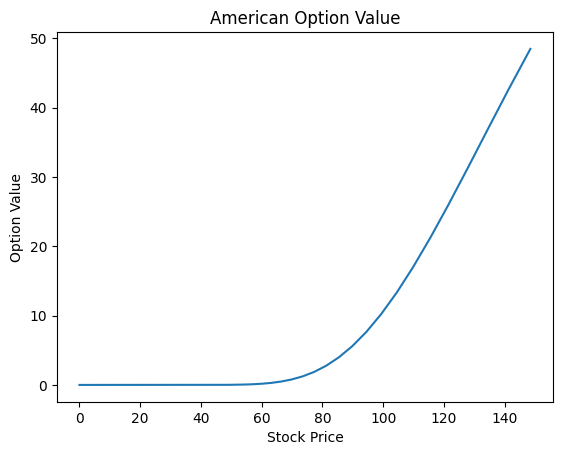

In [67]:
option_type = "call"

solver = CrankNicolsonSolver(
    riskfree=0.05,
    dividend=0.05,
    volatility=0.25,
    strike=100,
    maturity=1,
    option_type=option_type
)
solver.max_dt = 0.01
solver.USE_PSOR = True
price = solver.solve(100)
print(price)

import matplotlib.pyplot as plt

x = solver.S.flatten()
y = solver.X.flatten()
plt.plot(x, y)
plt.xlabel('Stock Price')
plt.ylabel('Option Value')
plt.title('American Option Value')
plt.show()

In [68]:
import sys
import os

project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))

src_path = os.path.join(project_root, 'src')
sys.path.insert(0, src_path)  
os.chdir(project_root)

print("src_path added to sys.path:", src_path in sys.path)

src_path added to sys.path: True


In [69]:
from Option import EuropeanOption

if option_type == "call":
    euro_price = EuropeanOption.european_call_value(1, 100, 0.05, 0.05, 0.25, 100)
    print(price - euro_price)
elif option_type == "put":
    euro_price = EuropeanOption.european_put_value(1, 100, 0.05, 0.05, 0.25, 100)
    print(price - euro_price)
else:
    raise ValueError("Invalid option type")

print("European Option Price:", euro_price)
    

1.1698071865792343
European Option Price: 9.462492596167081
